# Import dependencies

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

1 Physical GPUs, 1 Logical GPUs
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


# Load datasets and extract images

In [63]:
dataset = np.load('../Datasets/pneumoniamnist.npz')
print("dataset keys: ", pd.DataFrame(dataset).head())

# extract images
train_images = dataset['train_images']
val_images = dataset['val_images']
test_images = dataset['test_images']

# extract labels
train_labels = dataset['train_labels']
val_labels = dataset['val_labels']
test_labels = dataset['test_labels']

dataset keys:                0
0  train_images
1    val_images
2   test_images
3  train_labels
4    val_labels


# Get image dimensions

In [24]:
# get shapes
train_images_shape = np.shape(train_images)
train_labels_shape = np.shape(train_labels)
val_images_shape = np.shape(val_images)
val_labels_shape = np.shape(val_labels)
test_images_shape = np.shape(test_images)
test_labels_shape = np.shape(test_labels)

print("train_images_shape: ", train_images_shape)
print("train_labels_shape: ", train_labels_shape)
print("val_images_shape: ", val_images_shape)
print("val_labels_shape: ", val_labels_shape)
print("test_images_shape: ", test_images_shape)
print("test_labels_shape: ", test_labels_shape)

train_images_shape:  (4708, 28, 28)
train_labels_shape:  (4708, 1)
val_images_shape:  (524, 28, 28)
val_labels_shape:  (524, 1)
test_images_shape:  (624, 28, 28)
test_labels_shape:  (624, 1)


# Visualising images
1 is positive, 0 is negative (for pneumonia)

Test Image, case:  [1]


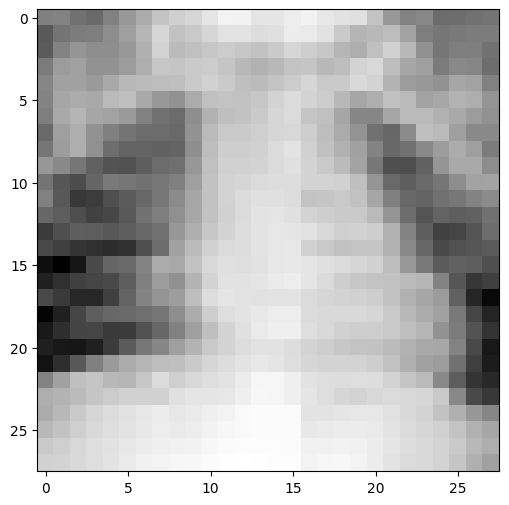

Test Image, case:  [1]


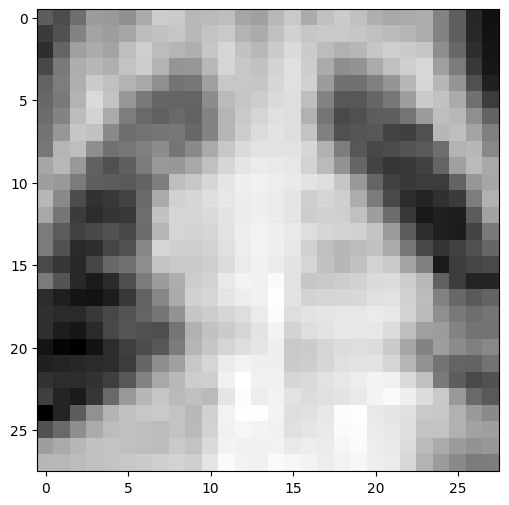

In [25]:
# 0 case
test_image = train_images[50]
test_image_label = train_labels[50]
# print('Test Image as array: ', test_image)
print('Test Image, case: ', test_image_label)
# Visualizing the same image
plt.figure(figsize=(6, 6))
plt.imshow(test_image, cmap='gray') 
plt.show()

# 1 case
test_image_1 = train_images[500]
test_image_label_1 = train_labels[500]
print('Test Image, case: ', test_image_label_1)
# Visualizing the same image
plt.figure(figsize=(6, 6))
plt.imshow(test_image_1, cmap='gray') 
plt.show()

# Normalize images to floating point, convert labels, and expand images to fit grey scale channel


In [26]:
# normalize images
train_images_norm = train_images.astype('float32') / 255
val_images_norm = val_images.astype('float32') / 255
test_images_norm = test_images.astype('float32') / 255

# convert labels
train_labels_conv = tf.keras.utils.to_categorical(train_labels)
val_labels_conv = tf.keras.utils.to_categorical(val_labels)
test_labels_conv = tf.keras.utils.to_categorical(test_labels)

# expand image shape
train_images_exp = np.expand_dims(train_images_norm, axis=-1)  # Add an extra dimension for the channel
val_images_exp = np.expand_dims(val_images_norm, axis=-1)
test_images_exp = np.expand_dims(test_images_norm, axis=-1)

# see new shapes
train_images_shape_new = np.shape(train_images_exp)
train_labels_shape_new = np.shape(train_labels_conv)
val_images_shape_new = np.shape(val_images_exp)
val_labels_shape_new = np.shape(val_labels_conv)
test_images_shape_new = np.shape(test_images_exp)
test_labels_shape_new = np.shape(test_labels_conv)

print("train_images_shape: ", train_images_shape_new)
print("train_labels_shape: ", train_labels_shape_new)
print("val_images_shape: ", val_images_shape_new)
print("val_labels_shape: ", val_labels_shape_new)
print("test_images_shape: ", test_images_shape_new)
print("test_labels_shape: ", test_labels_shape_new)

train_images_shape:  (4708, 28, 28, 1)
train_labels_shape:  (4708, 2)
val_images_shape:  (524, 28, 28, 1)
val_labels_shape:  (524, 2)
test_images_shape:  (624, 28, 28, 1)
test_labels_shape:  (624, 2)


# Create CNN model


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

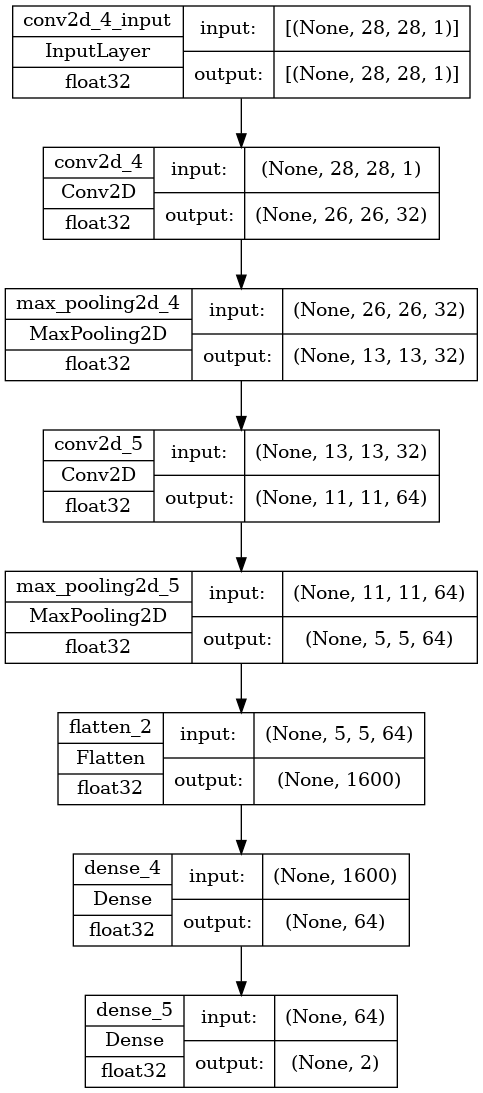

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=train_images_exp.shape[1:]),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(test_labels_conv[0]), activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# tf.keras.utils.plot_model(model, to_file='base_model.png', show_shapes=True, 
#     show_dtype=True)


# Train model

In [28]:
history = model.fit(train_images_exp, train_labels_conv, epochs=30, validation_data=(val_images_exp, val_labels_conv))

Epoch 1/30
148/148 [==============================] - 2s 10ms/step - loss: 0.3402 - accuracy: 0.8447 - val_loss: 0.2041 - val_accuracy: 0.9141
Epoch 2/30
148/148 [==============================] - 1s 8ms/step - loss: 0.1784 - accuracy: 0.9282 - val_loss: 0.1505 - val_accuracy: 0.9466
Epoch 3/30
148/148 [==============================] - 1s 8ms/step - loss: 0.1551 - accuracy: 0.9405 - val_loss: 0.1288 - val_accuracy: 0.9485
Epoch 4/30
148/148 [==============================] - 1s 9ms/step - loss: 0.1433 - accuracy: 0.9403 - val_loss: 0.1384 - val_accuracy: 0.9485
Epoch 5/30
148/148 [==============================] - 1s 8ms/step - loss: 0.1363 - accuracy: 0.9431 - val_loss: 0.1105 - val_accuracy: 0.9580
Epoch 6/30
148/148 [==============================] - 1s 8ms/step - loss: 0.1269 - accuracy: 0.9494 - val_loss: 0.1281 - val_accuracy: 0.9466
Epoch 7/30
148/148 [==============================] - 1s 9ms/step - loss: 0.1222 - accuracy: 0.9535 - val_loss: 0.1114 - val_accuracy: 0.9580
Epoch

# Plot training performance

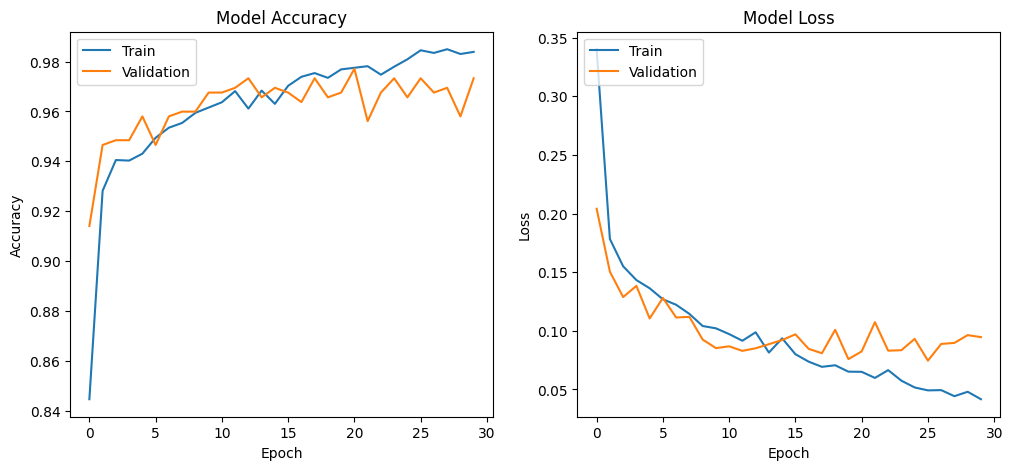

In [42]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# Analyse test accuracy w/ Confusion matrix

20/20 [==============================] - 0s 12ms/step - loss: 0.6756 - accuracy: 0.8766
Test accuracy: 0.8766025900840759
20/20 [==============================] - 0s 2ms/step


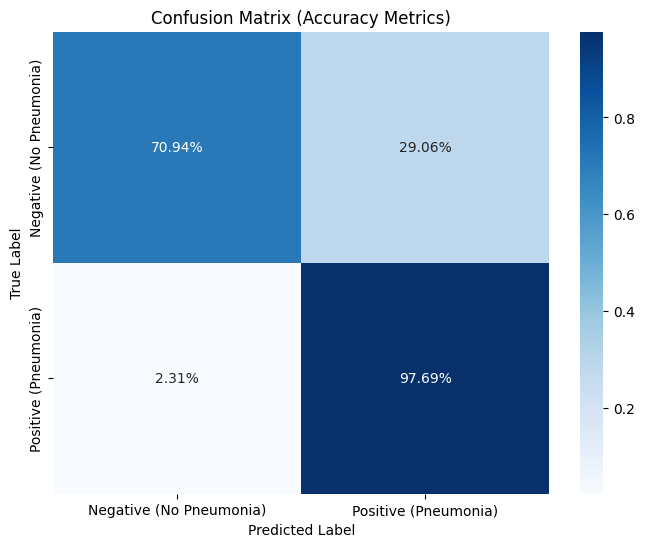

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_loss, test_acc = model.evaluate(test_images_exp, test_labels_conv)
print("Test accuracy:", test_acc)

predicted_classes = np.argmax(model.predict(test_images_exp), axis=1)
true_classes = np.argmax(test_labels_conv, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

TN_rate = TN / (TN + FP)
FP_rate = FP / (TN + FP)
FN_rate = FN / (TP + FN)
TP_rate = TP / (TP + FN)

cm_normalized = np.array([[TN_rate, FP_rate], [FN_rate, TP_rate]])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Negative (No Pneumonia)', 'Positive (Pneumonia)'], yticklabels=['Negative (No Pneumonia)', 'Positive (Pneumonia)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Accuracy Metrics)')
plt.show()

In [31]:
# Save the model
# model.save("task_a_model")

INFO:tensorflow:Assets written to: task_a_model/assets


INFO:tensorflow:Assets written to: task_a_model/assets


# Analyse Error Images

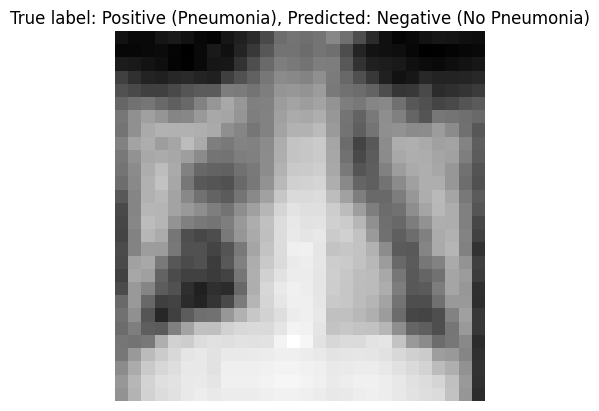

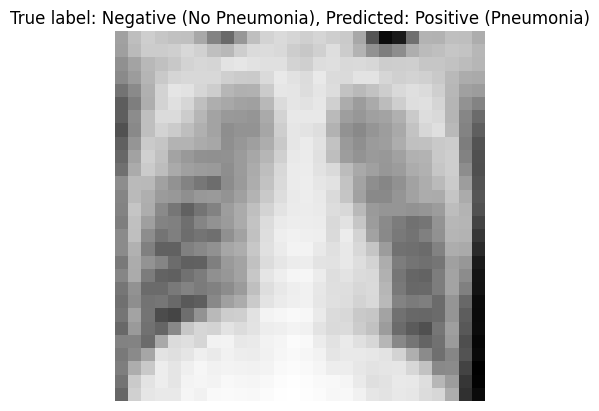

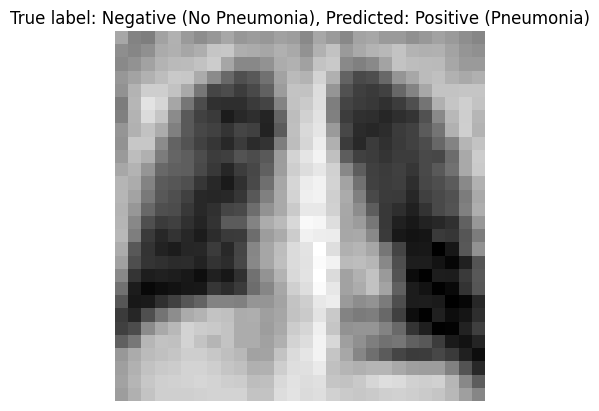

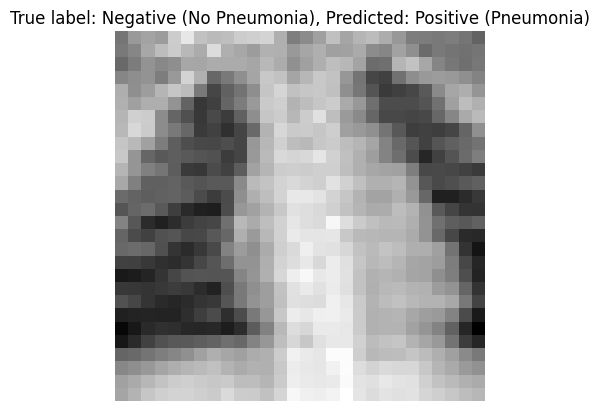

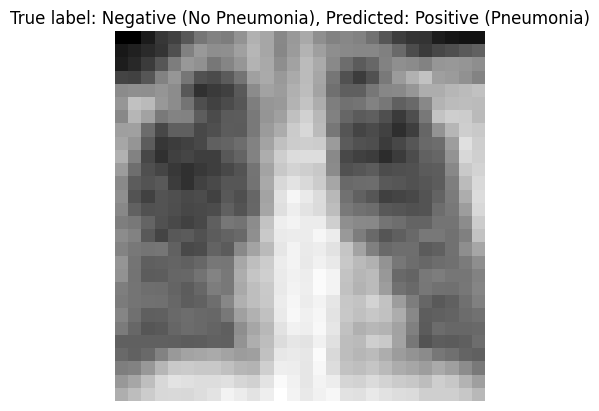

In [32]:
def label_to_string(label):
    return "Positive (Pneumonia)" if label == 1 else "Negative (No Pneumonia)"

misclassified_indices = np.where(predicted_classes != true_classes)[0]
sample_misclassified_indices = np.random.choice(misclassified_indices, 5, replace=False)

for i in sample_misclassified_indices:
    plt.imshow(test_images_exp[i].reshape(28, 28), cmap='gray')
    true_label_str = label_to_string(true_classes[i])
    predicted_label_str = label_to_string(predicted_classes[i])
    plt.title(f"True label: {true_label_str}, Predicted: {predicted_label_str}")
    plt.axis('off')
    plt.show()

# Analyse Distribution of data

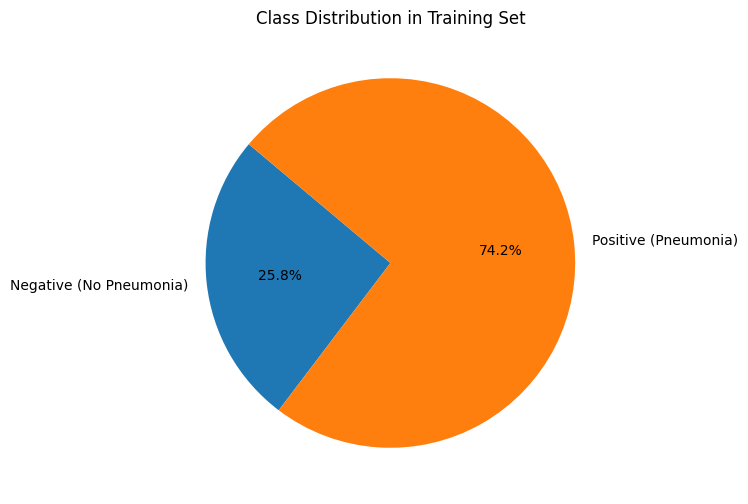

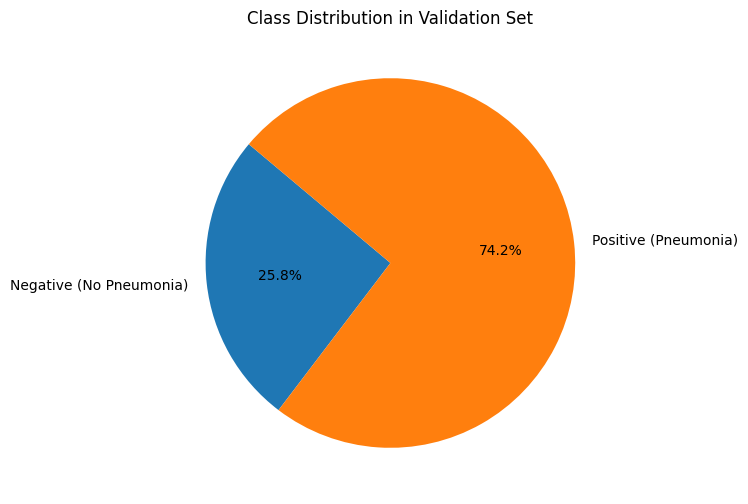

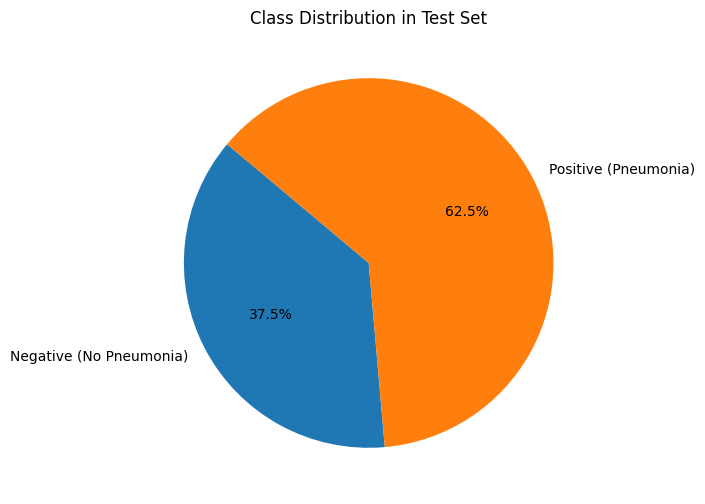

training count [1214. 3494.]


In [33]:
def plot_class_distribution(labels, dataset_name):
    class_counts = np.sum(labels, axis=0)
    class_labels = ['Negative (No Pneumonia)', 'Positive (Pneumonia)']

    plt.figure(figsize=(6, 6))
    plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.show()
    return class_counts 

# Plot distribution for each dataset
train_count = plot_class_distribution(train_labels_conv, "Training")
val_count = plot_class_distribution(val_labels_conv, "Validation")
test_count = plot_class_distribution(test_labels_conv, "Test")
print("training count", train_count)


# Augmenting new data
From analysing the results, it can be seen that the model underperforms when it comes to predicting negative class and also overfits. We can try data augmentation to try and balance the classes and reduce overfitting on the postive classes.

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import math

# get counts for negative and positive classes
negative_train_count = train_count[0]
positive_train_count = train_count[1]
# calc how much augmented data is needed
total_synthetic_needed = positive_train_count - negative_train_count
augment_per_image = math.ceil(total_synthetic_needed / negative_train_count)

# Identifying indices of the negative class
negative_class_indices = np.where(np.argmax(train_labels_conv, axis=1) == 0)[0]

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
)

augmented_images = []
augmented_labels = []

for i in negative_class_indices:
    img = train_images_exp[i].reshape((1,) + train_images_exp[i].shape)
    generated_count = 0
    for x in datagen.flow(img, batch_size=1):
        augmented_images.append(x[0])
        augmented_labels.append(train_labels_conv[i])
        generated_count += 1
        if generated_count >= augment_per_image:
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine with original training data
train_images_balanced = np.concatenate((train_images_exp, augmented_images))
train_labels_balanced = np.concatenate((train_labels_conv, augmented_labels))
train_images_balanced, train_labels_balanced = shuffle(train_images_balanced, train_labels_balanced)

# Compare original with augmented images

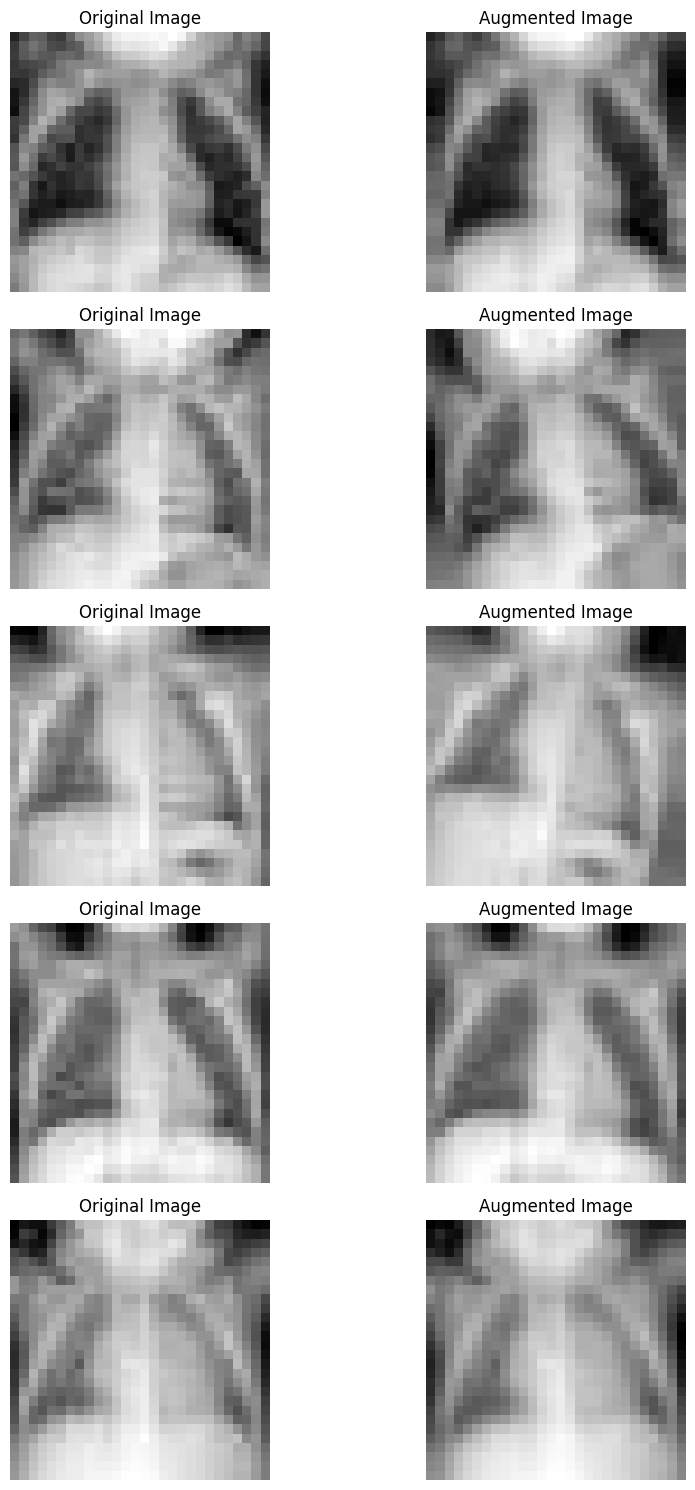

In [35]:
# Choose a small number of original images to display
num_images_to_display = 5  

# Set up a plot
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(10, num_images_to_display * 3))

# Select random indices from the negative class
sample_indices = np.random.choice(negative_class_indices, num_images_to_display, replace=False)

for i, idx in enumerate(sample_indices):
    # Display original image
    axes[i, 0].imshow(train_images_exp[idx].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')
    
    # Generate and display one augmented image
    img = train_images_exp[idx].reshape((1,) + train_images_exp[idx].shape)
    for x in datagen.flow(img, batch_size=1):
        axes[i, 1].imshow(x[0].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title("Augmented Image")
        axes[i, 1].axis('off')
        break  # Only generate one augmented image for comparison

plt.tight_layout()
plt.show()

# New distribution of training data

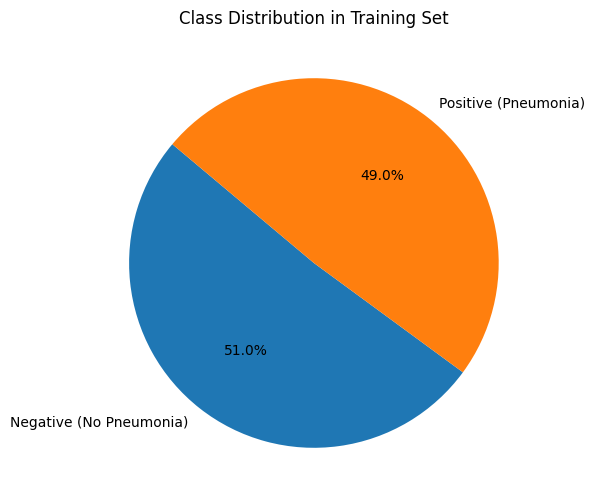

[3642. 3494.]


In [36]:
train_count_balanced = plot_class_distribution(train_labels_balanced, "Training")
print(train_count_balanced)

# Recreate and analyse the model using the new balanced training dataset

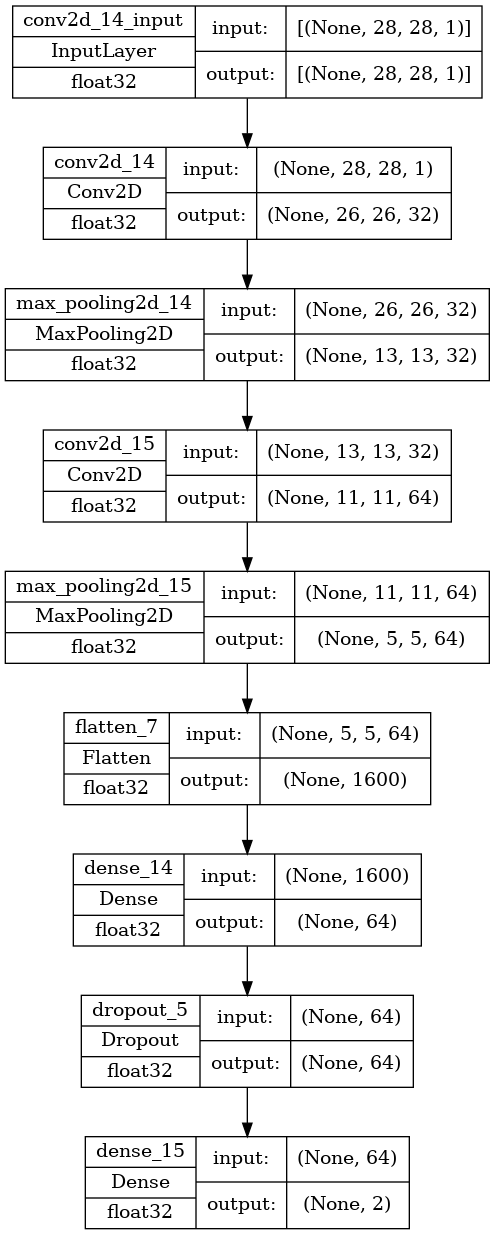

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define the L2 regularization factor
l2_reg = 0.001

model_balanced = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg), input_shape=train_images_balanced.shape[1:]),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.5),
    Dense(len(test_labels_conv[0]), activation='softmax')
])

model_balanced.compile(optimizer="adam",  loss='categorical_crossentropy',
                metrics=['accuracy'])

tf.keras.utils.plot_model(model_balanced, to_file='base_model.png', show_shapes=True, 
    show_dtype=True)


# Train new model

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model with early stopping
history_balanced = model_balanced.fit(
    train_images_balanced, 
    train_labels_balanced, 
    epochs=30,
    validation_data=(val_images_exp, val_labels_conv),
    callbacks=[early_stopping]
)

Epoch 1/30
223/223 [==============================] - 3s 10ms/step - loss: 0.4283 - accuracy: 0.8416 - val_loss: 0.2995 - val_accuracy: 0.8931
Epoch 2/30
223/223 [==============================] - 2s 10ms/step - loss: 0.2777 - accuracy: 0.9126 - val_loss: 0.2132 - val_accuracy: 0.9427
Epoch 3/30
223/223 [==============================] - 2s 9ms/step - loss: 0.2495 - accuracy: 0.9266 - val_loss: 0.3112 - val_accuracy: 0.8817
Epoch 4/30
223/223 [==============================] - 2s 10ms/step - loss: 0.2385 - accuracy: 0.9297 - val_loss: 0.1853 - val_accuracy: 0.9485
Epoch 5/30
223/223 [==============================] - 2s 8ms/step - loss: 0.2312 - accuracy: 0.9319 - val_loss: 0.1797 - val_accuracy: 0.9427
Epoch 6/30
223/223 [==============================] - 2s 8ms/step - loss: 0.2171 - accuracy: 0.9381 - val_loss: 0.1579 - val_accuracy: 0.9599
Epoch 7/30
223/223 [==============================] - 2s 10ms/step - loss: 0.1995 - accuracy: 0.9451 - val_loss: 0.1504 - val_accuracy: 0.9542
Ep

# Analyse new model

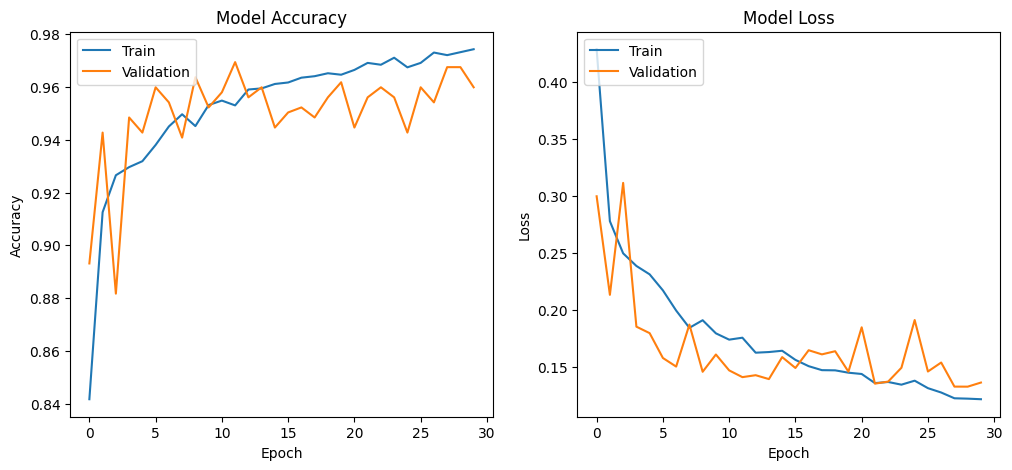

In [60]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_balanced.history['accuracy'])
plt.plot(history_balanced.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_balanced.history['loss'])
plt.plot(history_balanced.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


20/20 [==============================] - 0s 14ms/step - loss: 0.4817 - accuracy: 0.8606
Test accuracy balanced: 0.8605769276618958
20/20 [==============================] - 0s 3ms/step


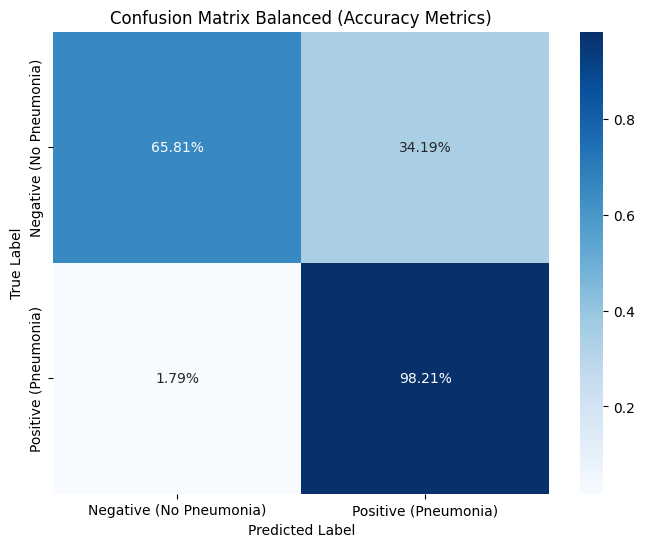

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_loss_balanced, test_acc_balanced = model_balanced.evaluate(test_images_exp, test_labels_conv)
print("Test accuracy balanced:", test_acc_balanced)

predicted_classes_balanced = np.argmax(model_balanced.predict(test_images_exp), axis=1)
true_classes_balanced = np.argmax(test_labels_conv, axis=1)

cm_balanced = confusion_matrix(true_classes_balanced, predicted_classes_balanced)

balanced_TN = cm_balanced[0, 0]
balanced_FP = cm_balanced[0, 1]
balanced_FN = cm_balanced[1, 0]
balanced_TP = cm_balanced[1, 1]

balanced_TN_rate = balanced_TN / (balanced_TN + balanced_FP)
balanced_FP_rate = balanced_FP / (balanced_TN + balanced_FP)
balanced_FN_rate = balanced_FN / (balanced_TP + balanced_FN)
balanced_TP_rate = balanced_TP / (balanced_TP + balanced_FN)

cm_normalized_balanced = np.array([[balanced_TN_rate, balanced_FP_rate], [balanced_FN_rate, balanced_TP_rate]])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized_balanced, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Negative (No Pneumonia)', 'Positive (Pneumonia)'], yticklabels=['Negative (No Pneumonia)', 'Positive (Pneumonia)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Balanced (Accuracy Metrics)')
plt.show()

In [41]:
# save model 
# model_balanced.save("improved_model")

INFO:tensorflow:Assets written to: improved_model/assets


INFO:tensorflow:Assets written to: improved_model/assets
